In [4]:
import os
import sys
import numpy as np
import neuroglancer
from skimage import io
import matplotlib
from pprint import pprint
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
from pathlib import Path
from tifffile import imwrite
import SimpleITK as sitk
from scipy.ndimage import zoom
PIPELINE_ROOT = Path('.').resolve().parent.parent
sys.path.append(PIPELINE_ROOT.as_posix())

from library.utilities.utilities_mask import normalize16

In [1]:
def compare_two_images(img1, img2):
    plt.figure(figsize=[20,20])
    plt.imshow(img1,cmap='Blues')
    plt.imshow(img2,alpha=0.5,cmap='Reds')

In [2]:
DATA = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/DK52/preps/CH1'
REGDATA = '/net/birdstore/Active_Atlas_Data/data_root/brains_info/registration'

In [5]:
filename = 'allen_10um_sagittal.tif'
fixedFilepath = os.path.join(REGDATA, filename)
fixed_volume = io.imread(fixedFilepath)
print(f'Fixed volume shape={fixed_volume.shape} dtype={fixed_volume.dtype}')

Fixed volume shape=(1140, 800, 1320) dtype=uint16


In [6]:
arr = np.swapaxes(fixed_volume, 0,2)
#arr = fixed_volume
fixed_midpoint = arr.shape[2] // 2
fixed_image = arr[:,:,fixed_midpoint]
fixed_image = np.rot90(fixed_image, 1, axes=(1,0))
fixed_image = np.flip(fixed_image, axis=1)
print(f'Fixed image shape={fixed_image.shape} dtype={fixed_image.dtype}')

Fixed image shape=(800, 1320) dtype=uint16


In [ ]:
del fixed_volume

In [53]:
# fx = 65500
# fy = 35500
# moving_volume around x=1200, y = 750 for 10um
# moving volume around x=600, y=350 for 25um
filename = 'aligned_volume.32.tif'
movingFilepath = os.path.join(DATA, filename)
moving_volume = io.imread(movingFilepath)
print(f'Shape before scaling: {moving_volume.shape}')
scale = fixed_volume.shape[1] / (moving_volume.shape[1] - 100)
print(f'scale={scale}')
moving_volume = zoom(moving_volume, zoom=(1, scale, scale))
print(f'Shape after scaling: {moving_volume.shape}')
#print(f'Scales: {moving_volume.shape[0]*scale} {moving_volume.shape[1]*scale} {moving_volume.shape[2]*scale}')
#moving_volume = moving_volume[:, 50:, 50:]
#print(f'Shape after scaling and cropping: {moving_volume.shape}')


Shape before scaling: (486, 1109, 2047)
scale=0.7928642220019821
Shape after scaling: (486, 879, 1623)


In [46]:
1/ 44 * 100

2.272727272727273

In [44]:
# Allen center of mass for SC: (368.08973894913635, 62.21607279887645, 227.68008600344592)
# from points.pts using center initalization [350.161977, 70.526061, 238.480457
# scaling_factor=64, COMPUTER SC [569.643591, 178.42558, 235.831656] 
# scaling factor 110, using NO center initial [360.939419, 69.148879, 218.973584]
scx,scy,scz = 647.63034, 216.404544, 229.740944
#7521 DK52 33 COMPUTER SC [277.901391, 104.727709, 209.847688]
# Moving image shape=(800, 1477)
roundedneuroglancer = [369,64,219]
fx = 65500
fy = 35500
print(fx/44, fy/44)

1488.6363636363637 806.8181818181819


In [ ]:
fixedImage = sitk.ReadImage(fixedFilepath)
movingImage = sitk.ReadImage(movingFilepath)

initial_transform = sitk.CenteredTransformInitializer(fixedImage, 
                                                    movingImage, 
                                                    sitk.Euler3DTransform(), 
                                                    sitk.CenteredTransformInitializerFilter.MOMENTS)

moving_resampled = sitk.Resample(movingImage, fixedImage, initial_transform, sitk.sitkLinear, 0.0, movingImage.GetPixelID())
moving_volume = sitk.GetArrayFromImage(moving_resampled)

In [54]:
arr = np.swapaxes(moving_volume, 0,2)
moving_midpoint = arr.shape[2] // 2
img = arr[:,:, moving_midpoint]
img = np.rot90(img, 1, axes=(1,0))
moving_image = np.flip(img, axis=1)
#moving_img = img[50:, 50:]

print(f'Moving image shape={moving_image.shape} dtype={moving_image.dtype}')
del img
del arr

Moving image shape=(879, 1623) dtype=uint16


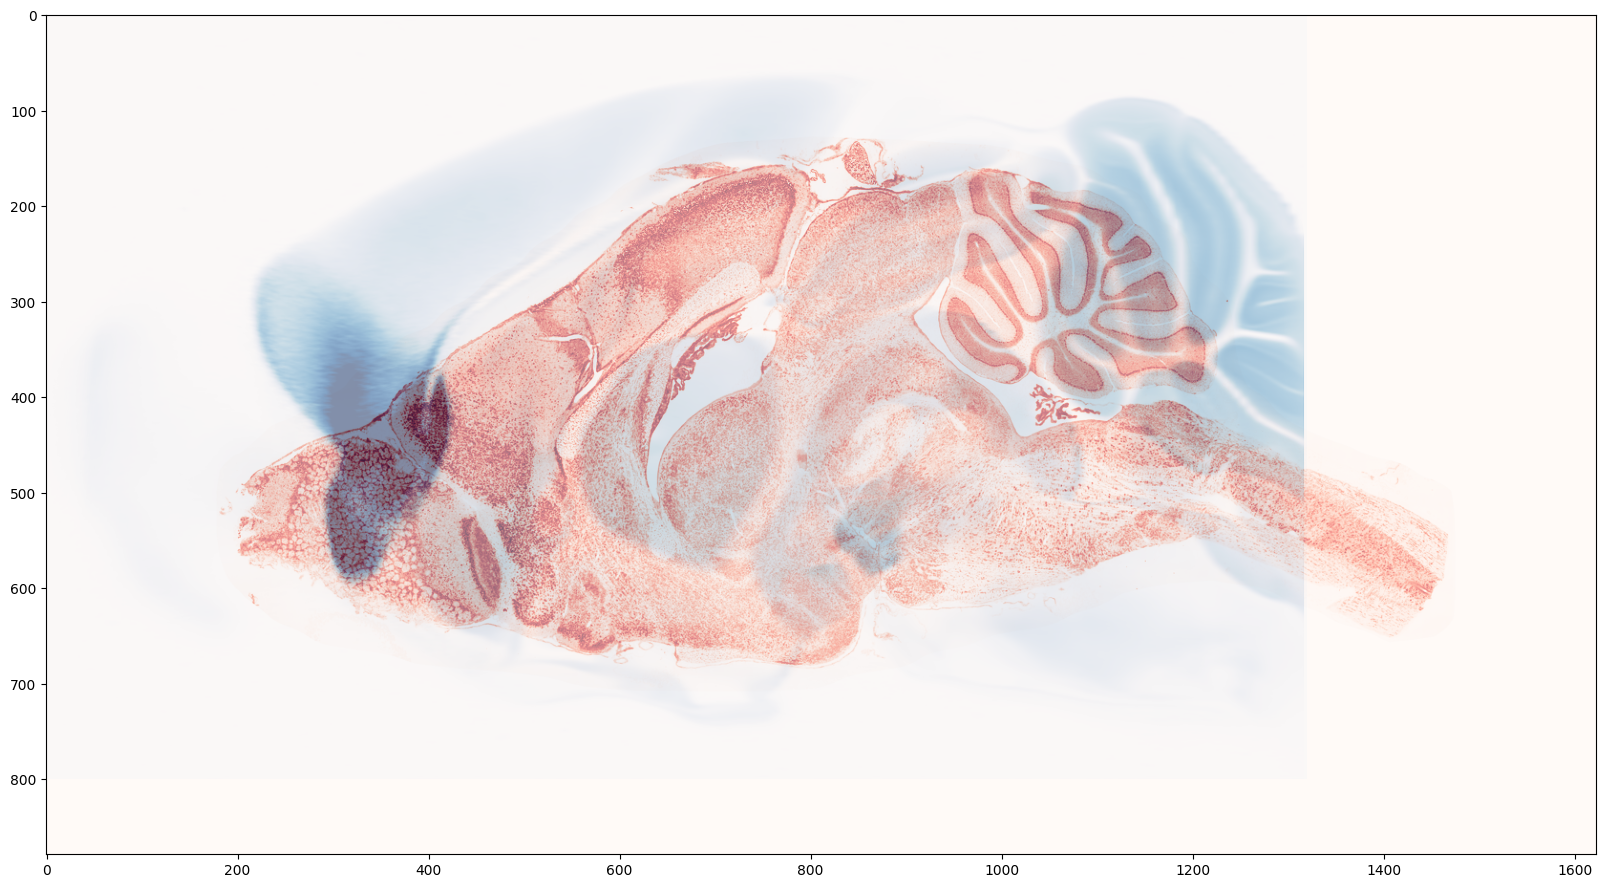

In [55]:
# blue is fixed, red is moving
compare_two_images(fixed_image, moving_image)

In [ ]:
# cornal to sagittal volume
arr = np.swapaxes(fixed_volume, 0,2)
#arr = np.rot90(arr, 1, axes=(0,1))
#arr = np.flip(arr, axis=0)
outpath = os.path.join(REGDATA, 'allen_50um_sagittal.tif')
imwrite(outpath, arr)

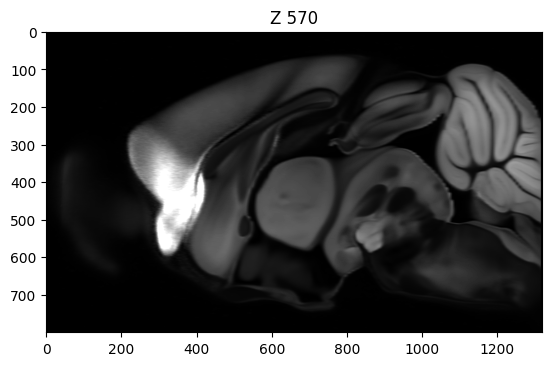

In [11]:
#arr = fixed_volume
plt.title('Z {}'.format(fixed_midpoint))
plt.imshow(fixed_image, cmap="gray")
plt.show()

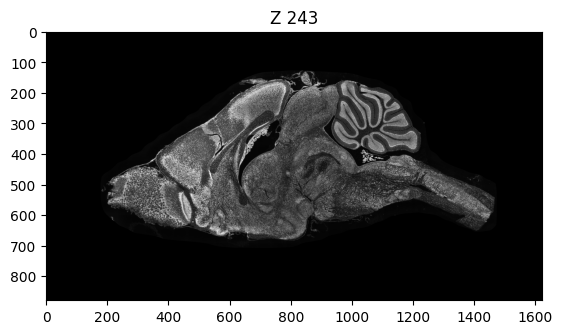

In [56]:
plt.title('Z {}'.format(moving_midpoint))
plt.imshow(moving_image, cmap="gray")
plt.show()

In [ ]:
#scaled = zoom(moving_volume, zoom=(1, scaler, scaler))
#print(scaled.shape)
outpath = os.path.join(DATA, 'scaled_volume.tif')
imwrite(outpath, moving_volume)
#vm2 = np.swapaxes(volume, 0,2)
#print(vm2.shape)
#outpath = os.path.join(DATA, 'allen_50um_sagittal.tif')
#imwrite(outpath, vm2)

In [ ]:
#arr = normalize16(volume)
arr = fixed_volume
print(arr.shape)
#arr = np.swapaxes(fixed_volume, 0,1)
midpoint = arr.shape[2] // 2
limit = 100
start = midpoint - limit
end = midpoint + limit
for i in tqdm(range(start, end, 10)):
    plt.title('Z {}'.format(i))
    img = arr[:,:,i]
    img = np.rot90(img, 1, axes=(1,0))
    img = np.flip(img, axis=1)
    plt.imshow(img, cmap="seismic")
    plt.show()

In [ ]:
image_stack = np.zeros(volume.shape)
file_list = []

for i in tqdm(range(0, volume.shape[2], 1)):
    img = volume[:,:,i]
    img = np.rot90(img, 1, axes=(1,0))
    img = np.flip(img, axis=1)
    filepath = os.path.join(OUTPUT, str(i).zfill(3) + '.tif')
    cv2.imwrite(filepath, img)

In [ ]:
# The default atlas created by brainreg is isotropic 25um
vm2 = fixed_volume
#print(f'Orig volume shape={sagittal.shape}')
#vm2 = np.swapaxes(volume, 0,2)
#sagittal = np.rot90(sagittal, axes=(1, 0))
#sagittal = np.flip(sagittal, axis=1)
print(f'new volume shape={vm2.shape}')

dimensions = neuroglancer.CoordinateSpace(
    names=['x', 'y', 'z'],
    units='um',
    scales=[10,10,10])
viewer = neuroglancer.Viewer()
with viewer.txn() as s:
    s.dimensions = dimensions
    s.layout = '4panel'
    s.layers['Princeton'] = neuroglancer.SegmentationLayer(
        source=neuroglancer.LocalVolume(
            data=vm2,
            dimensions=dimensions,
            voxel_offset=(0, 0, 0),
        ))

print(viewer)